In [ ]:
import asyncio
from openai import AsyncOpenAI
import pandas as pd
import nest_asyncio

nest_asyncio.apply()

MODEL = "Qwen/Qwen3-8B"

client = AsyncOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
    timeout=600
)

async def summarize(row, index) -> str:
    resp = await client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": row["prompts"]}],
        max_tokens=512,
        temperature=0.1,
        extra_body={
            "chat_template_kwargs": {"enable_thinking": False}
        }
    )
    usage = resp.usage
    
    return {'index': index,
            'summary': resp.choices[0].message.content.strip(),
            'completion_tokens': usage.completion_tokens,
            'prompt_tokens': usage.prompt_tokens,
            'total_tokens': usage.total_tokens}

async def summarize_many(table: list) -> list[str]:
    return await asyncio.gather(*(summarize(row, index) for index, row in table.iterrows()))

In [3]:
table = pd.read_csv("../data/buffer_table.csv")
table

,url,h1,text,full_text,lengths,compiled,lengths_compiled
0,https://docs.moodle.org/403/en/2D/3D_structure...,2D/3D structure display short answer,"{'header2_name': 'Overview', 'text': 'The 2D/3...",## 2D/3D structure display short answer\n\n###...,1429,###Overview\nThe 2D/3D Structure Display short...,486
1,https://docs.moodle.org/403/en/2D/3D_structure...,2D/3D structure display short answer,"{'header2_name': 'Features', 'text': 'Interact...",## 2D/3D structure display short answer\n\n###...,1429,###Features\nInteractive - students can rotate...,295
2,https://docs.moodle.org/403/en/2D/3D_structure...,2D/3D structure display short answer,"{'header2_name': 'License', 'text': 'This plug...",## 2D/3D structure display short answer\n\n###...,1429,###License\nThis plugin adopts the same licens...,117
3,https://docs.moodle.org/403/en/2D/3D_structure...,2D/3D structure display short answer,"{'header2_name': 'Authors', 'text': 'This plug...",## 2D/3D structure display short answer\n\n###...,1429,###Authors\nThis plugin was developed at the I...,146
4,https://docs.moodle.org/403/en/2D/3D_structure...,2D/3D structure display short answer,"{'header2_name': 'Requirements', 'text': 'This...",## 2D/3D structure display short answer\n\n###...,1429,###Requirements\nThis plugin requires Marvin A...,232
...,...,...,...,...,...,...,...
9684,https://docs.moodle.org/403/en/using_jquery_da...,using jquery datatables in moodle,{'header2_name': 'Loading DataTables from CDN'...,## using jquery datatables in moodle\n\n### In...,4982,###Loading DataTables from CDN\nThis is how I ...,2784
9685,https://docs.moodle.org/403/en/wikindx,Wikindx,"{'header2_name': '', 'text': 'Notes on the pos...",## Wikindx\n\n### Wikindx\nNotes on the possib...,9006,###\nNotes on the possible integration of WIKI...,621
9686,https://docs.moodle.org/403/en/wikindx,Wikindx,{'header2_name': 'CMS Integration with WIKINDX...,## Wikindx\n\n### Wikindx\nNotes on the possib...,9006,###CMS Integration with WIKINDX\nFrom MG:\nWIK...,997
9687,https://docs.moodle.org/403/en/wikindx,Wikindx,"{'header2_name': 'Wikindx filter for Moodle', ...",## Wikindx\n\n### Wikindx\nNotes on the possib...,9006,###Wikindx filter for Moodle\nFrom MG:\nDan's ...,4197


In [4]:
long_texts_table = table[table.lengths_compiled>2300].copy()

prompt = "Needed summary for my RAG search system! Summarize this text in 350-400 words:\n{chunk}.\n\nWrite ONLY summary without prefaces and afterwords!"
prompts = long_texts_table.apply(lambda row: prompt.format(chunk=row["text"], full_text=row["full_text"]), axis=1).to_list()
long_texts_table['prompts'] = prompts
print(len(long_texts_table))
long_texts_table.head(4)

668


,url,h1,text,full_text,lengths,compiled,lengths_compiled,prompts
28,https://docs.moodle.org/403/en/AMOS,AMOS manual,"{'header2_name': 'AMOS tools', 'text': 'AMOS T...",## AMOS manual\n\n### AMOS manual\nAMOS stands...,12966,###AMOS tools\nAMOS Translator tool\nAMOS Tran...,8069,Needed summary for my RAG search system! Summa...
36,https://docs.moodle.org/403/en/ASCIIMathML,ASCIIMathML,"{'header2_name': 'Display Usage', 'text': 'Asc...",## ASCIIMathML\n\n### ASCIIMathML\nNOTE: With ...,6742,###Display Usage\nAsciiMathML has been massage...,3961,Needed summary for my RAG search system! Summa...
53,https://docs.moodle.org/403/en/About_clusters,Lesson clusters,"{'header2_name': 'What are clusters?', 'text':...",## Lesson clusters\n\n### Lesson clusters\nClu...,5342,###What are clusters?\nA cluster typically con...,3239,Needed summary for my RAG search system! Summa...
88,https://docs.moodle.org/403/en/Accessibility_n...,Accessibility notes,"{'header2_name': 'Guidelines', 'text': ""The Wo...",## Accessibility notes\n\n### Accessibility no...,14119,###Guidelines\nThe Worldwide Web Consortium (W...,2303,Needed summary for my RAG search system! Summa...


In [5]:
long_texts_table.prompts.str.len().describe()

count      668.000000
mean      4770.642216
std       4027.968427
min       2472.000000
25%       2941.000000
50%       3677.500000
75%       5148.500000
max      61781.000000
Name: prompts, dtype: float64

In [ ]:
summaries = asyncio.run(summarize_many(long_texts_table))

In [5]:
summaries_table = pd.DataFrame(summaries)
summaries_table = summaries_table.set_index("index")
summaries_table[summaries_table.completion_tokens>450]

,summary,completion_tokens,prompt_tokens,total_tokens
index,,,,
357,This guide explains how to create a Moodle blo...,474,8804,9278


<Axes: >

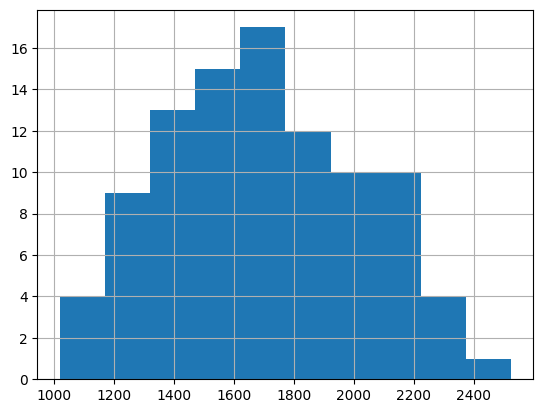

In [6]:
concated_summary = pd.concat([table, summaries_table[['summary']]], axis=1)
concated_summary.dropna().summary.str.len().hist()

<Axes: >

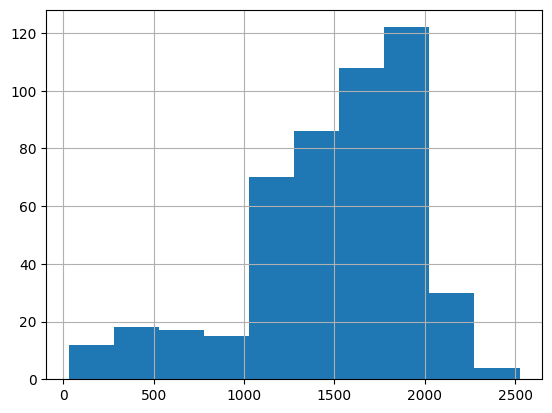

In [7]:
concated_summary['summary'] = concated_summary['summary'].fillna(concated_summary['text'])
concated_summary.summary.str.len().hist()

In [ ]:
concated_summary.to_csv('../data/summaries_new.csv')
concated_summary